In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython
import numpy as np

In [3]:
%matplotlib inline

In [4]:
import os

modelname="5_20_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 d_model: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 ff_scalar: int = 2):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, d_model)
        #Positional encoding
        self.pos_encode = PositionalEncoding(d_model)

        self.decoder_layers = []
        
        bottleneck_size = d_model
        ff_size = ff_scalar*bottleneck_size

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(d_model, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(d_model))
            #Add bottleneck layer
            layer.append(nn.Linear(d_model, ff_size))
            #Now add bottleneck layer norm
            layer.append(nn.LayerNorm(ff_size))
            #Add feed forward
            layer.append(nn.Linear(ff_size, d_model))
            #Now add layer norm
            layer.append(nn.LayerNorm(d_model))
            
            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(d_model, n_features)
        
        
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_bottleneck = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            d_ff = decoder_layer[4]
            d_layer_norm_3 = decoder_layer[5]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)
            
            #do bottleneck
            res = d_bottleneck(res)
            #layer norm
            res = d_layer_norm_2(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_3(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0, split: str = "\n"):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte
        self.split = split

    def tokenize_str(self, sentence: str, encoding = "utf8") -> torch.Tensor:
        base = [int(i) for i in bytes(sentence, encoding)]
        if len(base) < self.n_pad:
            base.extend([self.pad_byte] * (self.n_pad - len(base)))
        assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding = "utf8") -> torch.Tensor:
        # tokenize the input text
        sentences = []
        for sentence in texts:
            sentences.append(self.tokenize_str(sentence).unsqueeze(0))

        return torch.cat(sentences, dim = 0).to(self.device)
    
    @staticmethod
    def prepare_texts(document: str) -> typing.List[str]:
        return filter(lambda x: len(x)!=0, document.split(self.split))
    
    def sequences_to_texts(self, texts: torch.Tensor, encoding = "utf8") -> typing.List[str]:
        out = []
        for seq in texts:
            chars = []
            i=0
            while i<len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i+=1
            out.append(bytes(chars).decode(encoding, "replace"))
        return out

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], n_pad):
        self.raw_data = data
        self.tokenizer = Tokenizer(n_pad, device, split = "\0")
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return self.tokenizer.tokenize_str(self.raw_data[index])

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode("utf8","replace")

In [14]:
class WarmupScheduler:
    def __init__(self, duration, start_factor):
        self.duration = duration
        self.start_factor = start_factor
        self.factors = np.linspace(0, 1 - self.start_factor, duration)
        self.step = 0

    def get_lr_factor(self):
        if self.step >= self.duration:
            return 1
        res = self.factors[self.step] + self.start_factor
        self.step += 1
        return res

In [15]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 768
batch_size = 32
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
print(f"Head size: {head_size}")
n_layers = 12
BATCH_STEP_SIZE = 8
CLIP = 0.5

Head size: 12


In [16]:
path_to_data = "data/reddit_scrape_v4.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

51454


In [17]:
model = Transformer(d_model = embedding_dim, n_self_heads = head_size, n_features = n_features, n_layers = n_layers)
model=model.to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{count_parameters(model):,}", "trainable params")

57,154,816 trainable params


In [19]:
input=next(testloader_iter)
input=input.to(device)
print(input.shape)
res = model(input)
print(res.shape)

torch.Size([1, 512])
torch.Size([1, 512, 256])


In [20]:
lr = 4e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
warmup_sched = WarmupScheduler(10000, 0.01)

In [21]:
n_epochs = 40

In [22]:
!nvidia-smi

Sat May 20 09:31:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   66C    P0    78W / 150W |   1708MiB / 23028MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
print(device)

cuda


In [24]:
prompts = [
    "Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.",
    "Hello world, ",
    "How to use ChatGPT? How should I use ChatGPT?",
    "My code does not work. What should I do? I have been working on my code, and it does not work.",
    "Why is this code not working: `1+\"A\"`? Can you help?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?",
    "What is coding?",
]

Epoch 1


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. the an an ang an t t t t t t t t t t an the t t t t t an an t t an the t an an t t an t the at t t an an t at at t the t t the an t t t t an t t at t t an t t t an t at t an t at at t t t t t the t the an t t an t an t t t t t t t t an at the t t at t t an an t t t t t t an at an t t the t t an an t an an the t an an t t t an an an an an the t an t an an the the athe an at an the at athe an an t t the an an an an the t an an t t t t the an an t an t t t the t an an an an an an an an an an an an t the the t an an an an an an an an an an the the the an ang ang an an an ang ang the an an an an the an the an t an an t an an an the t athe an an an the an an t and t athe t athe an an an an an an an at the ang an t an ang an an an an

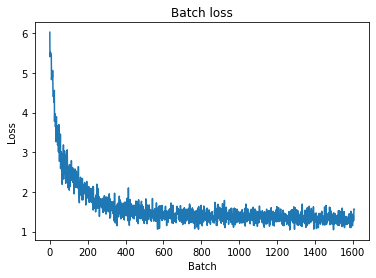

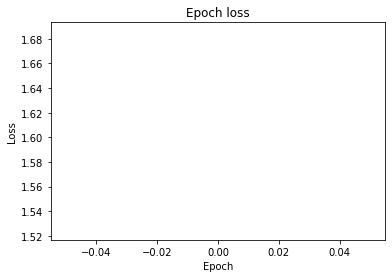

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. t t an t the the the the the the t t an the t the t the the the an the the the t the the the t t the the the t t athe the the an t t an the the the t the the the the the the the t an the t the the the the the t the the the the the t t the t the the the t the t the t the the the t the the the an the the t the t t t the the the t the t the the the the the the the the t the the the the the the the the t the the the t the t the athe athe t t ange the the the an the athere are are the the the the the the the the athe are an an are an athe the are the are athe are an athe athe the the the athe the the the the the an an the the the the the the an athe the the the the the the athe athe an athe athe the athe athe athe an athe an ath

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. the the t t the t the the the the the the the the the the the the an the the the the the the the the the the the the the the the the the the the the the the the the the the the t the the t the the the the the the the the the the the the the the t the the the t the the the the the the the the the the the athe the t t the t the the the the the the the the the the the t t the the the the the the the the the the athe the the the the the the the athe the the the the athe the the the the t the the the the the the the the athe athe athe the the the the the athe the the the athe the the the the the the the the athe the the athe the there the the athe the the the the the there the athe athe athe the athe the the the the the the the ath

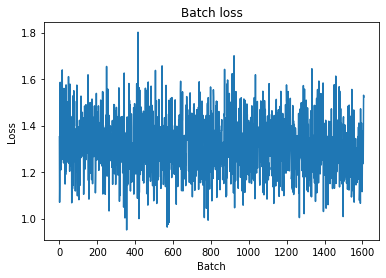

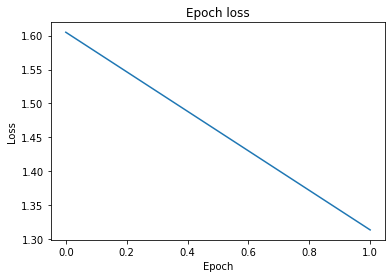

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. t t the t t the the t the t t the t t t the the the the the t the t the an the the the the the t the t the the the the the the t the the t the the the the the the the the t the the the the the the the the t t t the t t the the the the the the the the the the t the t t the the the t the the t the the the the the the the the the the the the the the t the the the the the t the the the the the the the t t the the t the the t the t the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the there the the the the and athe the the the the the the the the t

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. an an an an an anoure an an an an an ano an and anout an the an an an an ano ano an an an ano an an an an an an an an an an an an an an an anouthe an an an an an an an an an an an ano an ano an ano an an an ane an an an an an an an an an an an an an an an an an ano an an an an an an an an an an anoure an an an an an an an an an an anoure anour an ano an ane an an an an an an an an an an anoure an an an an an an an an ane ane an an an and ane ane an an an an ane anoure an ane ane an an an an ane ane an an an an anoure ane ane ane an an and and ane ane anoure ane ane ane and and ane ano an an an an an an an an an an an an an anoure an an anoure and and and and and anouthane ane ane ane and an anone anoure ane an ane anononore an

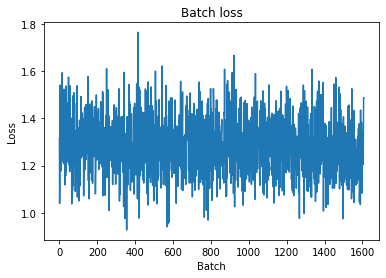

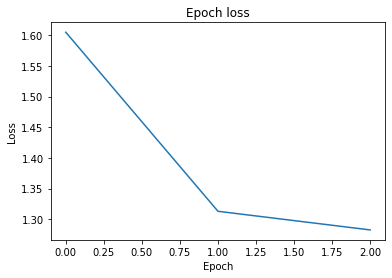

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. an an the a an a a ano a a the the a a a a a a a ano a a a a ando the a the the a a the a a the the a a a a a a the a a a a a a a a a a a a a a the a a a and a and a a a a a a a a a ano a a a a a a a a a a a ano a a a ano a a a a and a the a a a a a a a a a a a and the a a a a a a a a a a a a a and a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a arerea and a a a a a a a therererea a a a a and andorea a a a and a ando and theand and ano a a arerere a a a a a a a a a a tha a a a a a a a a a a a a a a a a a a a and a and a a a a a a a a a a a a and and a a a a a a a a tha a a a a a a a a a a a areandorea tha areand andofoforeand and arearerereareandeand arerea a a a a and and a a and a and and tha a

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I the t the the the t the t the the the the t the t the the the t the the the the so t the the t the so t t t so the the t the t the the the sthe t the the the sthe the t t stherere t sthe t t so the the t t the sthe t t the there t the t the the t the the t t therere the there t st the t the the the t t therere s t the t the the the t t the the the therere the t st t t there the t therere s t t t therererere therere t t t sto st st stherererererererererererere thererererererere t t t t t therererere the t the the the t t there therere thererere the the thererere t therererere there the the the the the t the s s s the the there there the therererererere thererererererere thererere therere the there there the t there therererer

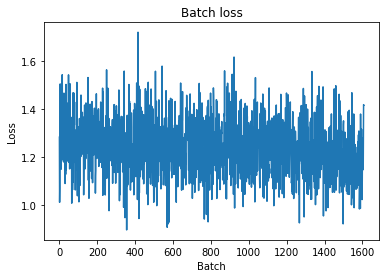

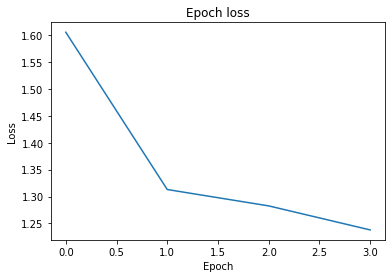

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I the and the and a a the a the a a a a a a a the se a and and the and and the a the a a the a and a a and the a a the a a the a a a a a soure a and and a and and and anout and and the the a a a a and a anouse the t a a a a a the a a a and a a a a a a a a a a therea sea a souse a the the t the se a a the a the a se a se the the the the the s a se the t t the the s the a se sere the t sere s se the therere t an serere t se sere se se an therere the there there are arere t s arere s t the s t serere the there the the the se an the the the there the the the the the the t the the therere t t t the t the the t the s s an thererere therere the the thererere t the therererererere the and the there an the the the t t there the ther

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the sthere there the the the the the the the the the the the the the the the the the the the the the the the the the the the the there the the the the the the the the the the the s the there the s therere the the there the the the t the the the the t thererere the there the the there the t therere t thererere the thererere t the the the there thererere t the the the the thererere the the the t the the the the there therere there there therere therererere there the t the t the ther the the the the therere therere the thererererere the the therererere thererere the the the the there there t the the the therer

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I the would the the the win the the sthere the the ther the the the the stherer there ther ther there ther there the ther the the the the the ther there ther there ther the ther ther the the ther the there ther there there there there ther there thers there there ther there the therere there therere thererer therere there therere therer thererererere thererere therere therererere therererererere t therererer.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, you do det work a the werk or of the deat aterer? I work work work the work the werk work work the werk work the werk werk the werk the the are werk would the the werk the werk the the the the werers the werk the the there the there thers there there there ther there the there there ther there there there there there the wererers therer there the there therere there there thererere t thererere there thererere therere therererere t therererererere t thererererererers.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I a would the the work a the the the at a the are the the the the the the the the the the the ther the there the the ther there there ther there ther ther there the ther there the there there ther there ther ther there the the there thers there the there ther there there the there there therere thererers there therere therere there therere thererere thererer therere thererers therere thererere thererere thererererere t thererererererererererer.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work. I the woulld the wit the the the the the the the the there the the there there there the ther there the there ther there ther there the therere ther thers there ther ther ther the there there there therer there there therer there there there there therere therere therere therere therere therere thererere thererere thererererere thererererere t therererererererererere thererererererere thererers.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help? the o o the o of or the the the o the win the the the the the werk of there the there the ther wererk there there there there ther there therers there therer there there there there therer therers therer thers ther there there thers there therer therer there there there there therer therers therere therere therere therere thererere thererere therererers therere therererererer thererererere therererere therererererererere thers thererererererererererer.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I do what a the do a the a the the the the the the the the are the at the at the the athe there there ther there there there the there the there ther the there there there ther there thers the there ther there there there ther ther ther the the ther ther there ther there there ther there ther the the there thers there ther there there there therere the thererere there therers there thererers therererer therererere therere thererererererere there therererererer.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java? I do wa the a the a work a a the a the a a progering a a the a the perere of the ther ther ther are a the the ther there arere the there ther there ther ther there ther the therer there there ther therer therer ther ther ther ther ther there ther there ther therer ther there therer ther there ther there werer therer there there there therere therere thererere therere therere thererers therererere therere thererererere t therererererererererere thererers.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help? I would the the the the the the the the the ther the the the the the the the ther ther the the ther ther ther the the ther there ther there the therers there there therer there therere therere ther there therere therer therere there therere therers therere thererere therererer there therererererere there therererere therererererere therererererere therers.


Prompt 8: What is coding?
Model output (markdown): 

What is coding? I do the the do the wo the do there the werk ould the werk of the werk the werk o the werk work the werk win the the werk the were the the the there there wererere there there therers thers there therer there therere there therer there there thers there there therere therere there therer there there there there there thers thererer therer there there therere therere therere there thererers thererere thererere thererererererere t thererererererers thererererers thererererererer.

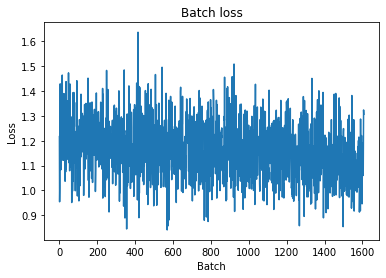

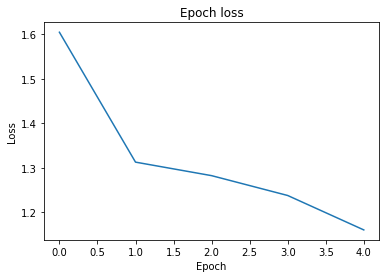

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I the a a a a the a sompe an the a a a the a some and a the a a some to a the a a seme are and to the a a a a some a and the a are and a the a a some are and are and a a the a a some the are are and areand and areand are the are are are are the the ar are are are are are the ar are the are ar are are the ar the are are the the the ar ar the ar the ar are ar the ar are ar are ar the the the the the the the the t s are the s are s the the are are the the are the lllllllllllllllllllll t t the the the the the t the s the the are are the are are the the t the the the the the are are the t the the t the the the s are the are the the the the the the the the the the there there the the t t the are the the the the t the the the ther

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I am and a to the make and and to the are are and and areare are the are are are aremating and and the are are the are are are areme and the are are areme and and the are are the are are are are the are are are are are the are are are are the are are are arere arer are the are are are the are are are are are the are are are are the the are the are are the the the are are are are the the the are the the are are are the there the the are are the are the the the thererere are the t t therererererere t there t the there the arerere the are arerere are arere t therererererere arerere are t are t arer are the arere are are are arererere are the arere the t the the arerererere arere are arere are t there the arerere arerere therere a

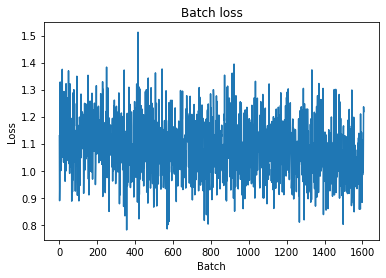

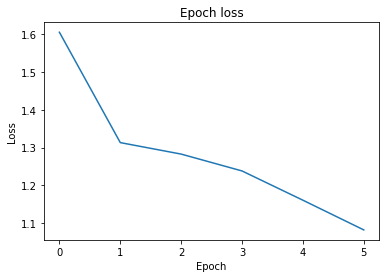

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I the are to are are to ar are to the are are are are the are are to are the are are areal to the are are to the are are to the are are are to the are are are the are the are to the are are the are the are are the are the are the the are the the ther are the the the ther the there the there ther there the there there there there there the there ther there there ther there there therere t thererere t thererere tererererer t tererererererer t thererererere t therererererererererer t t t therererererererer t t therererererererererererer t therererer therererer t thererererererererererer t t t t thererererererererererererererererer t t therererererer terererererererererererererererererererer t t terererererererer terer t t ther

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I am and a to the complent of to the arough and of the are arouge of the of the are arouge a arof the are are arof the are are are the are are are arof the are are the are are are the are are ar the are are are are the are are the are are the are ar ar are the are are the are ar the are the are ar are the are the are the of the the the the the thear ar the the the the the the thear t thear t thear t the thear t thear t the the t thear the the the the t theare t there the t therer t the there the ther the t thear t theare t the t thear the the t there there ther ther there thear t t t the t there thear ther the the the the thear t t t the therere t there thearere ther thear t t t theare t t t theare the t t thear t theroooooor 

What is coding?
I ant and an the are and to a the are and a to a complent and a the are and a to a a the are and a a to the are and a to the are and a to the are and a to a the are and a to a the are alls a and to the an the are and to the ar and a to the are an the are and to the ar an the als a a the the ar and to the the are all a the are the are the the ar all to the the ar all to the the the are the the the the the the the the the the the the the the the the the the the the the t there t.


=========================== BATCH 1500 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I wars to worith to the programmment to the torement are to the are torat arear the arear the toreat or the are the arear the toreme the tore the arear tore the the oreat the torem the torem the the prorat of the there them they tore the the torem the there they tore they they there they tore there the there they there there there there ther there ther therer there ther there therer thery therere therer thery thearer t thererer therery thererer thery therer. therererererery t therererer thererer thery thery thery therererererery thery therery therer thery thererererererererery ther therery ther thery thererer therererererer thery thery therererererery thererererererer. thererererery therer ther ther ther ther therery therere

Why is this code not working: `1+"A"`? Can you help?
It the ware the are and to the orear and the areat the arear the arear the arear arear the tore the the are the tore the are the they orear the orear the the are the they orear the the they they to the they orear the they tore the the they tore the they tore the they they tore the they they they they tore the they there they thear there they there they there the ther there the ther therery ther ther thear the there thery there therer therery therer therer.


Prompt 5: Why is Java better than Python?
Model output (raw): Why is Java better than Python?
It woriten the to the do the to defferent the to the peren of the the tore and the oreat the are the aread the torem the the torat an the the tore the torement the orear the the they tore the the they tore the the they they tore the they they tore the they they they they tore the they they tore the they they they toure the they toure the they tore the they they tore the ther the they ther they there ther there ther there thery thear there ther therer thery theary ther thear t therer thery thear thery thererer thearer ther ther thery thererer therer thery thear thery thear thear thear thery therer thery therererery theary therery thery thery thery thear therererererer thery thery theary thear thererery thery ther therearearearery ther therer thear thear ther ther therer thererery thererererer therery therery thear ther ther ther thearereary thearer thererererer thererery thery ther therer ther

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I ware to to the commmany to the can areat tore the tore the the they orear the the oreme the to the the programmment to the torem the the tore the they orear the the they tore the they tore the they tore the they tore the there they there tore the there there they tore the there the thery there there there therer thery thear there therer therer therer therer.


Prompt 8: What is coding?
Model output (raw): What is coding?
It don't the the down the offiner the they offer the they are the aread the arear the the are the aread the are the the arear the tore the are the arear the the are the areat the toreat the are the the they ore the the they orear the they they tore the the they they deat to the they tore the they tore the they they they tore the they they they they tore the they they there they there they there ther the they there ther thear ther there thery thear therer thear there thery theary ther thearer t thear thererer therer therery thearer therery therer therer therery therer thery thearer thear theary theary theary thery thery therererererererery thererer ther ther ther thearer thearer thearererer thery thear ther ther theary thery thearery theary thererererer therear thear ther ther thear thearererererer therer theary thererearery ther ther ther thery thearery thearerer therererer thererererery thererer therer thererer ther ther t

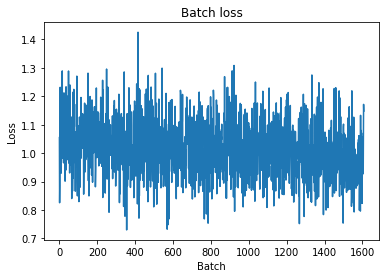

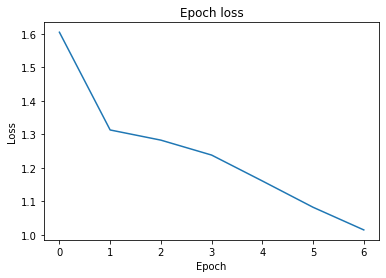

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want to the commenting arout the are arour the are are to the commmenting and to the commenting and to the commenting and to the carat arom arout to the commmmating all or the commmmmating and to the carat arout the or the carat arom the the protic to the carat aroun to the the commmmenting or the prog to the the proge to the the the the proring tow the the to the the the the the t proror t tor the t ther the tor t the tor t the t the ther t the the t ther t theror t t t thery t the t theror t t ther t the t t theror t t theror t t t theror t t thery t theror t t theror t ther t t t t t t theror t t theror t t theror t ther t t t t ther t theror t t t t theroror ther t t t t ther t t ther t t t the t t t theror t t theror

Why is Java better than Python?
I would the to the do the are a the are a the arat a the are a the are are a the are are the are are the are are the are are the are are aror the are the are are the are are the are are the are are the are are the are are the are are the are are the are are the the are are the are are aror the are the are the the som the the are aror the are the are the are the the are the ar the are the the the the the ther the the the ther the the the the t pear t tin t therere t the ther t the t thery llllllll t t t theare t t toror t t ther t thear t t ther t the ther t thear t t thear t t t t theary t ther t thery t thererer lllllllllllllll.


Prompt 6: Why is Python better than Java?
Model output (raw): Why is Python better than Java?
I does this a the are a the are arout the are a the arat are a the are are the are are the are are the are the are are the are are are the are are the are are the are are the are are the are are the are are the are are the are are are the are are the are are are the are are the the are are the are are the are the are the to the are the are the are the ar the are the are the the the the ther the the the ther the to the the the the ther the t are t there t thear t the t there t there t t thear t t thery llllllllll t ary t t t t thear t t theare t t theare t t t thear t t thearear t t t t theare t t theary t t theare t t therear t t t t thear t t t theare t t t thearor t t thear t t t t thearear t t t t t t thearorory t lllllllllllllllllllllll t t t t t t t t t t t t torororororor t t t t t t t thearoror t t t t t t t torororor t thearor t t t t t t t thearor t t t thearororororor t t t t t t t 

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I wor the compent or the commend of the commend on the commend on the commend on the comend on the compen on the code on the code on the commenting on the code on the the complene of the code on the of the comenting of the the comenting on the the code on the the comen on the compent of the the comen on the the con the the the the pere the the the the the the the the the the the t ther the the t ther the t the ther t ther t. were t ther the t the the t ther t therer t the t t there t t therer t ther t the the t t t there t there t t ther there t t ther t ther t therer ther t t ther t t t t therer t t therere t t t therere ther t t t t t therer t t therere t t thererererer t t t t t t t therer there t t t t t t t t ther therere

Why is this code not working: `1+"A"`? Can you help?
I would the complent of the code of the code on the of the compant of the compendent of the code on the the code on the of the complent of the code on the complenent of the code on the or the coment of the code on the of the code to the compention on the code the the code to the comenting on the the compent of the the compenting of the the the coment to the the the the the con the the the the the the the the the t the the the t ther the the t the t ther t.


Prompt 5: Why is Java better than Python?
Model output (raw): Why is Java better than Python? I work and arough are the complent of the commendent of the code on the of the commend of the code on the of the complenent of the code on the of the compendent of the code on the of the comend on the or code on the or the comenting on the code on the the code on the the code on the of the the comenting of the code on the the code to the the con the the coment on the the the con the the the the the the the the the the the the the t ther the t the the the t ther t ther t ther t the t ther t there t the t t there t ther t t ther t ther t t t therer t ther t t ther t the t t ther t t ther ther t t ther therer t t t t therer ther t t t t t the t t t t thererer t t ther t there t t t t t ther t t t ther t t t t therererer t therer t t t t t ther t t t t t t t t thererer t t t thererer t t t t ther t ther t t ther t t t t ther t t t t ther t t t tororor t t t t t t t t t t t therororor t t t t t t 

Why is Python better than Java?
I the the complent the of the complent of the the code of the the complenent of the code on the of the code on the of the code the of the the code on the of the compention on the of the code on the of the comenting on the code on the the coment on the code the the comenting on the the code to the the code to the the the code to the the the the coment to the the the con the the the the the the the the the the the the the the the the t ther the t the the the t the t ther the t.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (raw): What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help? I would the code on the or the comment of the code of the comment on the comens of the comens of the comens of the comend of the comens of the comens on the comens on the comenting on the comens on the compenting on the the compenting of the of the the coment of the the the peren the the the the the the the the the the the the the the ther the t ther ther the t there t ther the t the the t ther t ther the t ther ther t there t t ther t ther t ther t there t t the t ther t therer t t ther ther ther t ther t t t ther thererer t t ther t t the t ther t t therer t the t therer t ther t t t ther t ther t t ther t ther thererererere t t t t t t t t t there t t t therer t t t therorerer t t ther t t t

How to use ChatGPT? How should I use ChatGPT?
I want the be to bo the person of the person of the perent of the perent of the perent of the perent of the perent of the perent of the perent of the semet ore the perent of the sere the peret of the the perent of the semet the ore the perent of the the perent of the the perent of the the perent to the sear the seare there the sear the the perent of the the they were the the the peret to the the the ther the ther the ther the ther ther there ther.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (raw): My code does not work. What should I do? I have been working on my code, and it does not work. I would the be be arout the comenter of the peret of the perent of the perent of the peret of the perent of the perent of the sere of the perent of the perent of the ore the perent of the seare or of the ore the perent of the seare the ore the sear or of the ore the ore the perent of the the perent of the the peres. It wherer there the the there there there therer there therer therer thererer. therere therer thererer ther therer therererer. thererer therererer thererer ther thererer therererer ther therer. therererer therer therererer therer. thererererer thererererer ther ther ther therererererer thererererererererers ther therer therer. thererererererersther. therererer therererer ther thererer thersther thererererererer thererererer therererer ther thersther thersth

Why is this code not working: `1+"A"`? Can you help? 
I want the to book of the of the problem of the comention on the code on the code on the comenting on the code on the code on the code on the cometing on the code on the counction on the code on the colle the code the the code to the code to the code the the care the the sell to the sere the the peret to the the peret to the the the pet to the the the ther the the ther the the ther the ther the the the the ther the the ther the ther ther ther ther.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python? 
I would the be of the be of the perent of the perace of the perent of the or and or and the semet the sear the sear the sear ar and the seer the sear the sear the sear ar and the see ther sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the sear the the sear the the sear the the the sear the the the ther the the ther the the the ther the the ther the the ther the ther they ther ther ther.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I the are the they of the offere the person of the perent of the perent of the perent of the perent of the perent of the perenter of the perent of the or and of the seme the perent of the seme the peresss of the semet ore the perent of the perent of the perest of the seare there or and the sear are the sear the sear the there sear the sear the the sear the they sear the the sere the the ther the the ther the ther the ther the the the ther ther the ther ther therey ther ther.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help? 
I want to the sear of the peore of the perate of the perest of the perest of the ore the courese on the corould the or the perent of the ore the perent of the seare the perest of the the perent of the the petiont ore the ore the perent of the the peret of the the there the perent to the the perent the there the there ther there the therer ther there ther ther.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I do at about the saring a programming the problem of the perople of the people or and and the seme and of the seme the semeting and of the seme and of the perople of the semetings or and and arouth the seare are and the seer the sear the sear the seard to the sear are ard the sear the sear the sear the sear the the sear the sear the the sear the the sear the the sear the the the sear the the the the sere the the the the ther the the the the ther the the the ther ther ther they there t therer t.

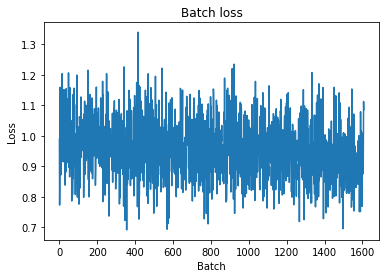

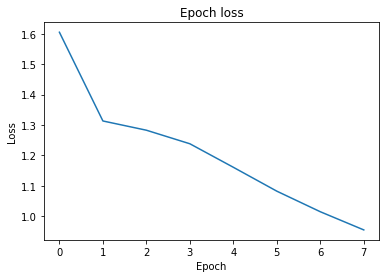

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I ware to work to the complent aror to the complent of the complent of them to complent or to the complention on the complention of the complention on the complation on the code to the complention on the complention on the to colll ton the the complentiontion on the to colll to the complentiontion on the to con to the complentionting on to the the are to the to the to the to the the the the the tin tin tin tin tit tin tit. t tery tery thellllll t tet the t tory torere tery the thery te the the t thery. thery theret thet ther tit t thery thery thery thery titit. thether ther. thet t tery tither thether t thar tit thererethet. tit t t titet titer titit t tery. tetery titery. thetitit ter ter ther ther thethet tititit tit thit

How to use ChatGPT? How should I use ChatGPT?
It working anytond the work a to bot any with and to the complent of the complention to code to the complention to the complention to code to the complention to the code to the complention to the complention on the code to the comple on to the complention to the complention to the complention to the complention to the code to to the to colll to the the to the to decontion ting to the to the the tor to the the to the the the tor the tor the the t.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I would to the bot arout the complent of the complent of the complention to comple on the complenting on the complention to code to to the complention to the complention on the complention on the to code to the to code to the to the complention to the complention to the to complention to to the complentiontion to to the to complention ton to the the to the to the to the the the the tor the tin tin tit.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I do you commplent and the complention to code any work to the complent and to the complent of the complention to complention to complention to code to the complention on the code to the complation on the to code to the code to the to complention to the complention to the complention to the complention to the complention to the complentiontion to the to conde to the the the to dene to the the the to the the the the the the thelll.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't this be that doest any the offinent that to the doest of that the to complent of the to complention of the complention to code to the code on to the code to the code to the to complention to the code to the complention to the complention to coden to the complention to the code to the to complention to the complention to to the complention to the complention to to the to the complention ton to the to the the to the to the the tin the the tin tin the tin tit tin tin t.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I does that the toolk of the that boother the office to the complention of the complenting of the complention of the complention on the complention of the code on the the complention on the code on the the commenting on the the code to the to complent on the to the complention to the code to the the complention to the complention to the complention to the complention to the to the commenting to to the to the the tor to the the tor to the the the the the the tin tin tin t.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I want to to the complent to the commenting on the comple of the complention to comple torating to the complention on the code to to the complention on the complention on the complention on the to code on to the consting ton to the the complentiontin to the to dition to the to the the to deating to to the the to the to the to the the the ther tin tin tit the tin tit.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I do and the stating to start and the start and the some that some that around to the around to the complent of the complention to code to the complenting to the code tome to the complention to code to the code to the code to the to code to the to code to the to code to the to complention to the code tomple to the complention to the complention to the complention to to the code to the to the the to the to deating to the the the to the the the tor the the the tor the the the tin tin t.


Epoch 9


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want to do they see the comend of the seme of the comend of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the secomene of the seme of the seare of the seche of the seare of the seme of the sear are of the see ther so the sear ar are the some of the seer the sear the sere the sor the wher the sor the the spere ther the the ther ther. wher the ther ther the the ther sther ther the ther ther ther ther ther then t ther ther ther. ther ther ther ther therer ther ther ther ther ther. ther thererer ther ther. ther ther t ther thether ther ther ther therethengheng. t thet ther thetheng. t therer. thethererer t t ther ther thethenget t t thet ther thether theth

Hello world, how do you how do you how do your?
I don't know who yourse the do yours and and the some of the some of the some of the seme of the seme of the seme of the seme of the sear of the seme of the sear are of the see of the sear ar of the seem of the sear are of the see of the sear of the seem of the sear are and the seem of the sear are and the some the sear the sear the sear ar the ar the some the the sear the the sear the the sear the the the spere the the the the the the the the the the the the the the t ther the the the the the the the the ther t ther t ther the ther ther the the the t the ther the ther ther the ther ther.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I do you have a see the comment of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seche the sear are and the seeme of the seme the sere the sear the sear the seem the sear ar the are the the sear the seem the the sear the the sere the the the ser the the the ster the the the the the the the the the the ther the t ther the ther t.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (raw): My code does not work. What should I do? I have been working on my code, and it does not work. I have a some the come of the coment of the coment of the comention of the seme of the some of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seche of the seme of the seme of the seme of the seme of the seme of the secence of the seare the sear of the sear ar the sear the or sear the sere the the ser the sher the the specen the the ther sher ther ther then ther the ther. sthe the ther ther the ther the ther ther ther ther ther ther t ther ther ther. ther ther ther the ther ther ther ther ther ther ther ther therer ther ther. ther ther thethe ther ther ther ther ther thethengheng. t thet t ther ther ther ther ther ther. therer t ther ther ther thethethet thet t thet ther ther thether thethether ther ther thengheng. thengr t theng

Why is this code not working: `1+"A"`? Can you help?
I don't work the are and any where the complent of the complene of the complent of the coment of the comention of the code of the complent of the comention of the complene of the comention of the comention of the comention of the comention of the comentiong of the comentiong of the comenting of the coment of the the people to the comenting of the the coment the the prow the the the complent to the the the the the the the ther the ther the ther the then ther.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I have they offere they offere they offere the ofference they offere the offere the programmment the complenter of the comentione of the comention of the comention of the comention of the comention of the comention of the comention of the comention of the people of the seme of the comention of the comentiong of the sec of the sece the the comenting of the coment of the the the perent to the sece the the the the the the the the the the the the the the the the ther the t ther the the t ther the the the the the the ther then t ther t the the the ther the the the t ther ther the ther t ther ther ther the ther ther.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I'm think of the stard the of the stard of the some of the some of the some of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the seme of the sear are and the seem of the sear are and the seem or the sear are of the seem the sear the sear the seem the sear ar the sear ar the sear the sear the the sear the seem the the sear the the sear the the sere the the the ser the the the sthe the ther the the the ther the the the the ther t.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (raw): What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help? I would be are the come or the come or the comention of the come of the coment of the coment of the comenter of the comente of the comentiong of the comende of the comentiong of the comenting of the comenting of the sec of the see the comenter of the comente of the comenting of the the perent of the the where the the the pretic. It where the wher there the wher there ther ther ther the ther ther ther ther ther ther ther ther. theret then ther ther thether t ther therer ther ther therer. ther therer ther therer ther ther thethether t ther. theng. ther thererer therer thethetheng. t ther thether theng. thether ther. thererer. thet thether ther ther thengher thet ther thethether thet ther t ther t

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I ware to do the say of the something of the solught of the solut of the solught of the solut of the solut of the sare of the or and of the sare around of the sare of the solught or of the solught of the peoration of the solught or the or or are to araticaly or to the sare to the sard to to the saring arout to to the corat ard to the to the to to the to to the to to to the to tor tor.


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, are aror aror or or or programming or aror aror aroror aror aroror aror aroror aroror aroror aroror aroror aroror aroror aroror aroror aroror aror aroror aror aror aroror aror aroror aror aroror aror aroror aror aror aror aroror aror aror aroror aror aroror arorating arorating arorating arorating arorating aror arorating aror arorating arorating arore aror aror aror aror aror aror aror aror aror aror aror to so arout aror.

I wark aror to to the are aror aror ar tor aror the tor.


Prompt 2: How to use ChatGPT? How should I use ChatGPT?
Model output (markdown): 

How to use ChatGPT? How should I use ChatGPT?
I work the at work of the something of the solve of the parent of the something of the solught of the profet of the solve of the parament of the something of the parent of the cometing or of the so to the pen of to the sarard of the sare around of to the sare around to the sare around to the sare around to the sore to the sear to the sare to the sore to the sore to the tore to the tore to the tore to the tor tor.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I would to have a be a lot of the cometaly or a profet to the comant oror a lot of to the saray of the saray of the or are aror and of the solut of the solught of the sare to the sare around of to the sare around to the sear to the sare arout of the to so to the sear arout to the sare to the to deat to to the to sear to the to the tor to to the to the tor to to the the t.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I would work at a something to come to come and of the comet of the solught of the code of the cometant of the code or a prot of to the cometantion or and to the cometaly or aror and to the sarat of the sare around to the cometally or aror the saric to the cometiontion or the corate ard to the sare to the corate to the corate to the corat to to the code to to the to the to the to to the to the to to to the tor the t.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I would the be of the of the ofice or a programming of the solught of the problem of the code or a problem to code and a were to and oto and a way to to aray arout and to the sarary arout of to the saray around and of the sare and to the sarard and to the sear around to the sear around to the sare around to the sear to the sear arout to the so to the seard to to the core to the to the to the to to the to the tor to to the the tor.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I work a the office the office or a problem of the coment of the something of the parent of the or aror and of the coment of the cometant oroly and the cometion oror and a procet of to the cometaly or and arout and to the saray arouther to the sear of the or and of the sare arout to the sare aro to the sare to the sear to the sare around to the corent to the code to the to the to the core to the to the to the to the to to the tor tor.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I would to have a bot to come or a prot of to the come or a profet or the cometaly or are aror the corater or aror aror the corate or the corate or the cometiont or the cometiont or the code to the corate to the corate to to the code to to the code to to the code to to the to code to to the to to the to to the to the tor too the tor.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I don't a solund the something of the sole of the process of the or and of the something of the problem of the solut of the sarare of the comentation or and of the sare around of the sare of the or aror and of the sare around to the saral around to the sare around to the sear around to the sem to the sear around to the sear around to the seare to the seard to the sole to the sore to the to the sare to the to the to the tor to the to the to to the t.

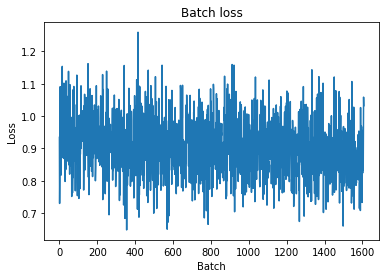

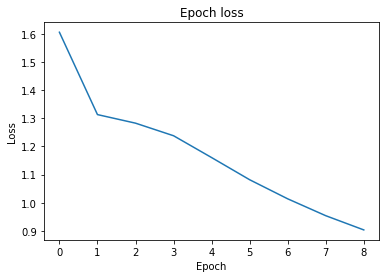

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (markdown): 

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I want the the work arout the work arout the work are the work or are the work arout and the were the work or ar arout the arare the work or the way work. It would the were work the work arout the ware are the work they work arout the way ware to the work.


Prompt 1: Hello world, 
Model output (raw): Hello world, arouter aror aror aror aror aror araror arorating aror aror aror aror araring aror aror aror arating arorating aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror aror the ar aror ar aror the aror ar aror the the the ar. there the there t therer. the there ther. there the t thererere t therere ther. there the the therer. therer. therere t therer.









Ithe there ther t thery t there the therere the therere the therer t therere ther ther t therere thererer. t there t thererererer. the ther t thererer there thererery therer. t therery therererer t t the ther. therer therererer therere t the ther therere therer. therererer the therer. t therer. there

How to use ChatGPT? How should I use ChatGPT?
I was the they don't the work of the work of the work or a the work or a working the arough arout the work or a the work or athere arouter the work or the way to do the the ware the the work or the were are the work.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I want the work arout the work arout the work or the work arout the work or ar a the work or aror a the work. It's als arout the wore the bok arout the work aror the were are the work or the were arating aror the work or the were the work.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I was a the come and the work arouting and the work arout and the works arout the company on the ware to the completer of the completer of the completer of the completen of the completer of the completer or the completer or the comention them work or the were aratior the the work or the were the distion the the were the the work the the the were the the work.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't think the work a the work a the work of the work at of the work of the work at work a the work at aroutious the arough the the commention on the work of the way to work.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I would the be a like the beter a lot of the programming of the work arouting and the work or and the works or a the comenting on the work or and the were the work.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I ware think they work arout are the work arout the work arout the wore are the work or the were aratious to the work or the were arating to the work or the were the work.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I all aready the don't work and and the work and the work arout and a lot an the work of a the work of aror a the comention on the completer of the completer of the completer of the completer of the completer of the code the the completer of the code an the ware are the code an the ware the the the distion at the the the the dis.


Epoch 10


  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want to are are to are are to arary are to aray are aror the company or are are to arather aror are aror the company arout are are to are arather aror are the are aror the are aror the programmmming and to see the solve are are to ar arathed aror the are are the are aror the are the are are the are the are the are the the are the the the are the are the the the ar the the the ar ar the the the the ther the ther. the the ther the ther ther the ther. the ther therer there ther. t there ther ther therer. the ther the there there ther. ther therererer. therer. thererererer. ther. ther. ther ther. thereretherere ther thether. therer. therererererer. therer. therererererer. therered thererer. therer. thether. therer. thereretherer

Why is this code not working: `1+"A"`? Can you help? 
I don't know what to company and a programmming and aror and and the programmmming and to completed are and arord and to completented and arord and the come are at around the are aror the company and and arot the come and to the come arate at arof the the coments and at the people to the care ard at to the the perate to the are are the the the are the the the the the the the the the are the the the the the the the the the the the the the ther.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I also a lot attoper and and and are the programmmming and the are around the completented of the code and and the company of the completent of the completed of the company and and and the company and a problem to the come and a profece to the complent and and at the are the the prograt and to the coment and a the the people to the are are the are the the the the the are the the the the the the the are the the the the the the the the the the the the the the the the the t.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java? 
I have a because a programmming and the some and and and the company of the company of the company of the company of the company of the complened of the company of the complenet of the companient and and arout the come and at a the parate and to the care are a the pare arof the the care ar aror the the peole the the perate to the are the are the the the the the the are the the the the the the the are the the the the the the the the the the the the the the the the the t ther.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (raw): What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help? I also are are are the come ar are are the come arathed aror are are the coment of the come are are are are the comentated arathed aror the come arat arathed are the are are the are aror the are the are arathed the are the are the are aror the are the are the are the are the the the perent the ar the are the the the are the the the ar the the ther ar the the the ther the ther. ther t there the the the ther ther. therere the the ther ther therer. there there the ther. there therer ther. therererer. ther. therererererer. thererer. ther. there ther. thererererere there thereretherer. therer. ther. therethererered ther. therererered thed ther. therererer. ther. therererererererererer. thererererere

Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
I want to the ware to do the ware to do the commund or the commund to the carate arout the comman and there the commund to be arout the commend to the carate arout the comman arout the comman torat the countating the the care to the comman to the carouge the the the comman toro the counting the the the the comman to the the count the the the the the the tor the the the tor the the the the ther the ther the tw ther ther tw ther.


Prompt 1: Hello world, 
Model output (raw): Hello world, how do your hard arouch arouther rarally around or the rating or ararathe aror aror arariting arorathe the aror aror aror aror the around aror aror the arough around the aror aror aror aror aror aror aror aror aror aror aror the aror aror aror aror the could arouch the bracket to around are aror aror aror the could around the aror aror the aror aror the aror aror the the aror aror the the could the the were the arough the the there the the ther the the ther the ther the ther ther. ther thet ther tw ther theror t thet ther ther ther tw theror t ther ther t ther ther ther ther thet t. ther t theror t ther theror t ther ther ther t ther theror t ther t ther thet t ther t theror t t therororor t ther t t ther ther t thet t t t tororor t theror t ther t t theror t t ther t t theroror t t t theroror thet t t t thet theror thet t t t t t therororor t t theror ther t t t t t t t theror t therororor t t toror t t ther t t t t t tororor t

How to use ChatGPT? How should I use ChatGPT?
I don't the ware to do the company or prot the commund the company or a prot the commund to the commund a be the comman and the commund to be a caroul are there aror aror the comman and there the comman to comman torough arout the toll be the commund to the comman toro the comman torout the could to the be the comman torout the the could to the the the the the the the the trough the to the the the the the the the the the ther the the the the ther.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (markdown): 

My code does not work. What should I do? I have been working on my code, and it does not work.
I want to the wart to do the commund to be a commund to be around the commund aror a better aror the commultute are aror the comman and therad the the comman torough arout the could to be arouth the counturent therough the the commultuly or aror the the counture the the commentating to the could to the be the torow the tough the the torough the to the the the ther tout the the the ther the ther.


Prompt 4: Why is this code not working: `1+"A"`? Can you help?
Model output (markdown): 

Why is this code not working: `1+"A"`? Can you help?
I don't work the are are the company or a programmming the commund a completent the completent aror the commund aror a coull are the commundating to comman them around the commend to communtation and therad the commundent or the commundating arout the could the be the coden to the commund to the comman torough the the could to the the be to the could to the the the the were the the the tor the the the ther the the ther the ther the ther.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't what you want to write to do the commund on the problem or a proten and the communiteng or around the company arout and the commund and the the commund and the commund and there the care arout the comman and the the carate them to comman to the carount arout the counture there the the communting or the comman to the comman torout the the count the the the the comman to the the the perot to the the the the the the tor the the the the ther the ther tw ther thet.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
In the are a problem a programming the completent or aror a programmming to completen the completente or aror arorad the companing and the commundent to be a completent the care arout the commund to be arout the comman and the the care arout the toll be the commundent to be the care aror the the the contan ther the the code to the the carould the the the could to the the the the the the the torough the the the the the the the the ther the the the ther tw ther.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (markdown): 

What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
I ware around the commund arout aror aror the commund aror aror aror the commulate aror aror aror the comman arout are the commentation and therad the commentation or aror the corom aror aror the counture the corecture the coreture aror the the corom torough the the could to the were the arough the torow the torok to the the theror the the theror the theror the theror.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
It all beter a problem a programming and the same around around the around around the company arout and the communitent arout around the communitent arout aror the commund and the the carate arout the comman and the the caroul aror aror the comman and the the commaning to carout arout the counting therough the commultion or aror the could the the were arout the arough the torat arout the torough the the the torough the the torow the torow to the the the the theror the the theror.

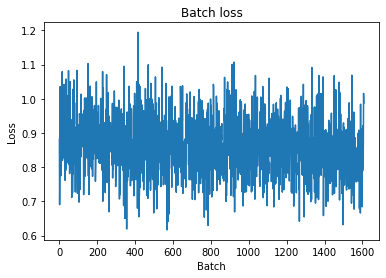

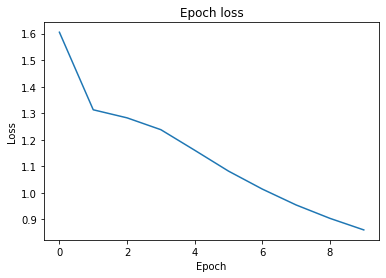

=========================== END OF EPOCH ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want to do ataly to work or are the araly arouth that work ard aratititity araly what arathe to work or ar arathing arout the word arly or of the wars on what you are are the arar aror aror arather or ar the araly or ar arathis aror aror the arar aror arathe aror arathe aror aror arathing aror arather aror arathis aror arathis arouth arather aror arathis aror arar arary arary ararithing arary arar arary arary arar arary arar arary arary ararary arary ararary ararary arary arary arary arare ararar ary ararary arar arararary ary arararar ary arary ary arararar arar ararary arary arar ararar ar arar arararar ar ararararary arary arary ary ararararar ary arar arary ararary ary arary arar are ar arar arar ar ararary arary arar

How to use ChatGPT? How should I use ChatGPT?
It would be the back a the word the work of the are araly the araly arouth the araly that work at arouth and the word ar and the ward to do ataly of the ar araly that was ard to the arather arouthe the araly that way don't at and the wars aron the around the ward to ward to the arad around the arar aror the aror and the wars arat and to ward to depend at ward ard and at ward to ar aratiting aror the aror ar that wat ard to the the thar ard that ard tat the theat t thear the the ther then thear ther ther ther ther ther thear ther then ther.


Prompt 3: My code does not work. What should I do? I have been working on my code, and it does not work.
Model output (raw): My code does not work. What should I do? I have been working on my code, and it does not work. I would the brak arout arathe around the word are arathing around the word arath around arout aratich of the arar arar aror arar arary aror arather aror aror arather aror arather aror arather aror aror aror arather aror aror arathis aror arather aror aror araticaly aror arather aror aror arather aror arather aror aror aratior aratior aror aratior aror arathis arary arary ararithis aror arar arary arary arar arary arary arary arararary arary ararary ararary araryous ar ararary ararary arary aryouthar ar ararar arararar arary ararary ary ararar arar arary arary arararar ary ararar ararary arar arararary arararar ary arary ary ary arararararary arar ary ararar ararary ary ary ararararar ar ar arar ararar arary arararary arar ar arararary ary ararar arathar ar ar arar ar a

Why is this code not working: `1+"A"`? Can you help? 
I don't work a what a wat to do the commund of the or ar and and what the word the word ar arath around the in the word ar ar and it work ard and arather the word ar arath around the arad ar aror the araly arouth the ward to work or ar arither arouth the arad aror the ward arout and the wars arout to arather arouth the aror aror the arar aror the aring arouth the araly aror the arither aror the arar aror the aror the ar ar that arit the ther ar thear the the the ther thear the the ther ther ther ther thear the ther ther ther.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
In also the different the commund of the arather and and the word and it work at arating and the word ar and it work at and and when you want to the word the word the word the are arather around the araly arouth the araly that word ard and when you ward to do it and at ward to the down at the that ward to the ar around to the ar arouth the ward to ward the ar around the arnd arouth the ward arouth ward and and at ward at arouth ther aror the the the the ar ar ard that the the ther the ther then the ther ther.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I don't work this any of a data and what the do work at and what the do work athing or and the word down athing and the word down at work or at and the word ar and the ward to do ataly arouth the araly that way do the wars and to work at and the wars a ward to do ataly arouth that arather ar the ar aror the arad aror way ard to ar and the araly arouth that ward arout and the ar aror the ward arout the ward arout ard to ward ard to ar the ar aror ar the the the ther the ther.


Prompt 7: What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help?
Model output (raw): What is the purpose of the main() function in C? I know that it is where the code starts executing, but I am not 100%. Can you help? I also arouth arouth the or ar araly the arar arathe the or ar araly that word are arather arar arar arary arouth the caraly arary arouth arather aror the araly arouthe the arar araly arouthis arather aror the arar aror aror arating aror arather aror aror aratition arather aror arathis aror arather aror arar arary arary arary arary ararithating ararary aror arar arar arary arary ararithing arar arary ararar ararary ararary ary ararary arary are arar arary ararar ararary ararar arar ararary arary ary ararary arararar arary ararary ary arar arar ararary arararar ary arararar arararary ary arary arararary ary arar ararary arary ary arararar ary arar ar arararar ar arararary ararary ary ararar arar

  0%|          | 0/1608 [00:00<?, ?it/s]

=========================== BATCH 750 ===========================
Prompt 0: Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure.
Model output (raw): Why does Earth orbit the Sun? I think it has to to with gravity, but I am not sure. I want to kind work at around at arough around to book around at around at around at arough around to are around around around around at aratice around aror aror aror aror way around ato are around ato arealy around around ato areatiors aror around are arord around are arord aror water around ato work.
I alwad aready aread around are the work around are aror water aroute arouth the around to wout are tout are ar arout ar ar arout ar ar areat the ar the toout t arout the ther ther tear ar ar ar arout the the the ar thear ar ar ar ar ar arouthe t thear thear t thear ar ar ar ar ar tear ar t aroout t t thet ar ar ar aroout t t thet ar t t thear ar thet t t aroooor t t t tear ar t thet ar t t t thear t t t thear ar t t toooooooor 

In [ ]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    
    for batch, data in enumerate(tqdm(dataloader)):
        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()

        if batch % BATCH_STEP_SIZE == 0:
            optimizer.param_groups[0]["lr"] = warmup_sched.get_lr_factor() * lr
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

        batch_losses.append(loss.item())
        
        if batch % 750 == 0 and batch > 0:
            print(f"=========================== BATCH {batch} ===========================")
            with torch.no_grad():
                for i, prompt in enumerate(prompts):
                    print(f"Prompt {i}: {prompt}")
                    output=generate(prompt)
                    if not output.strip().endswith("<CUTOFF>"):
                        print(f"Model output (markdown): ", end="")
                        IPython.display.display(IPython.display.Markdown(output))
                    else:
                        print(f"Model output (raw): {output}")
                    print()

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}.pt")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
        
    scheduler.step()    
    
    print("=========================== END OF EPOCH ===========================")
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            if not output.strip().endswith("<CUTOFF>"):
                print(f"Model output (markdown): ", end="")
                IPython.display.display(IPython.display.Markdown(output))
            else:
                print(f"Model output (raw): {output}")
            print()


In [ ]:
model = torch.load(prefix_models+"model_E0")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()